# Multiclass Classification with CNNs in Tensorflow

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import numpy as np
import pathlib
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

## Helper Functions

In [2]:
def view_random_image(target_dir, target_class):
  """
  Select an image randomly from target_dir and plot
  """
  target_folder = target_dir + "/" + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image[0])
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}.")
  return img

In [3]:
def plot_history(model_history):
  """
  Helper function to automate plotting a tf history object
  """
  df = pd.DataFrame(model_history.history)

  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  df.loss.plot(label="training loss")
  df.val_loss.plot(label="testing loss")
  plt.ylabel("LOSS")
  plt.xlabel("EPOCHS")
  plt.legend()

  plt.subplot(1,2,2)
  df.accuracy.plot(label="training acc")
  df.val_accuracy.plot(label="testing acc")
  plt.ylabel("ACCURACY")
  plt.xlabel("EPOCHS")
  plt.legend()
  plt.tight_layout()
  return plt.show()

In [4]:
def load_and_prep_img(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, col_chnl).
  """
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size=[img_shape, img_shape])
  img = img / 255.
  return img

In [5]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title
  """
  img = load_and_prep_img(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  # extra logic for multiclass
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]
  plt.figure()
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

## Import & preprocess data

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2021-08-16 05:30:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 74.125.71.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   110MB/s    in 5.2s    

2021-08-16 05:30:29 (94.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



There are 2 directories and 0 files in "10_food_classes_all_data".
There are 10 directories and 0 files in "10_food_classes_all_data/test".
There are 0 directories and 250 files in "10_food_classes_all_data/test/sushi".
There are 0 directories and 250 files in "10_food_classes_all_data/test/ramen".
There are 0 directories and 250 files in "10_food_classes_all_data/test/steak".
There are 0 directories and 250 files in "10_food_classes_all_data/test/chicken_wings".
There are 0 directories and 250 files in "10_food_classes_all_data/test/grilled_salmon".
There are 0 directories and 250 files in "10_food_classes_all_data/test/chicken_curry".
There are 0 directories and 250 files in "10_food_classes_all_data/test/hamburger".
There are 0 directories and 250 files in "10_food_classes_all_data/test/fried_rice".
There are 0 directories and 250 files in "10_food_classes_all_data/test/pizza".
There are 0 directories and 250 files in "10_food_classes_all_data/test/ice_cream".
There are 10 directori

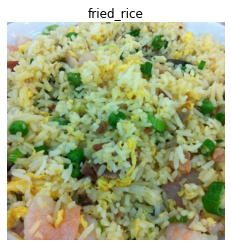

In [7]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in \"{dirpath}\".")

train_dir = '10_food_classes_all_data/train/'
test_dir = '10_food_classes_all_data/test/'

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(f"\n CLASS NAMES: {class_names}.\n")

_ = view_random_image(target_dir=train_dir, target_class=random.choice(class_names))

In [8]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Build a basic model

Model: "Baseline_tinyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)        

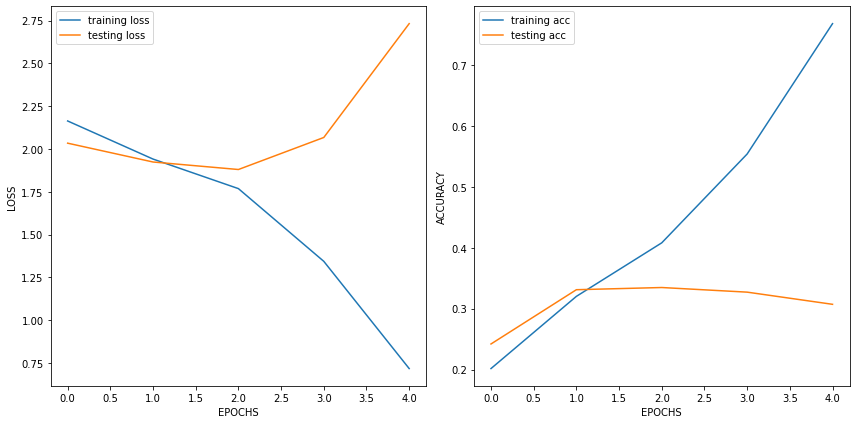


BASELINE MODEL ACCURACY: 30.7%.


In [9]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu",
                        input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation="softmax")
], name="Baseline_tinyVGG")

model_1.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

model_1.summary()
print()

history_1 = model_1.fit(train_data, epochs=5, 
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data))

print()
plot_history(history_1)
acc_1 = model_1.evaluate(test_data, verbose=False)[1]
print(f"\nBASELINE MODEL ACCURACY: {100*acc_1:.1f}%.")

## Tune hyperparameters to reduce overfitting

Model: "EXP2_Simplified_VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 29160)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                291610    
Total params: 292,800
Trainable params: 292,800
Non-trainable params: 0
_________________________________________

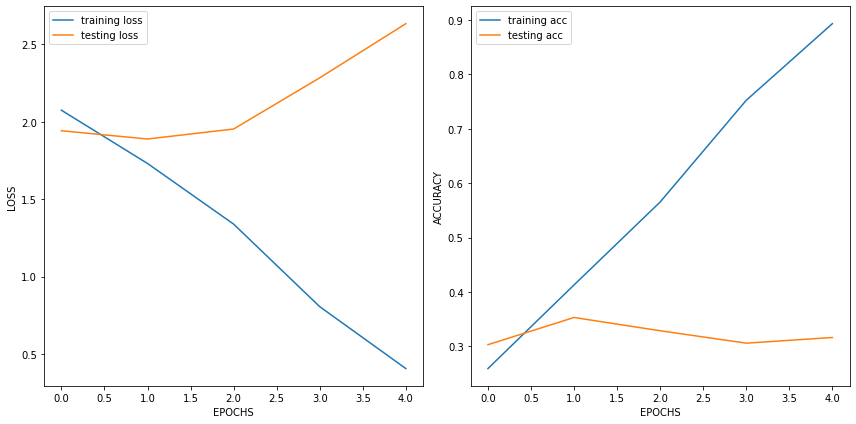


SIMPLIFIED MODEL ACCURACY: 31.6%.


In [10]:
# Begin by simplifying the model, by removing 2x conv layers
model_2 = Sequential([
  Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224,224,3)),
  MaxPool2D(),
  Conv2D(filters=10, kernel_size=3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation="softmax")
], name="EXP2_Simplified_VGG")

model_2.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

model_2.summary()
print()

history_2 = model_2.fit(train_data, epochs=5, 
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data))

print()
plot_history(history_2)
acc_2 = model_2.evaluate(test_data, verbose=False)[1]
print(f"\nSIMPLIFIED MODEL ACCURACY: {100*acc_2:.1f}%.")

> Removing conv layers doesn't simplify the model as conv layers reduce the parameter space... Let's try data augmentation instead.



Using augmented data:
Found 7500 images belonging to 10 classes.

Model: "Baseline_tinyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
__________________________________________________

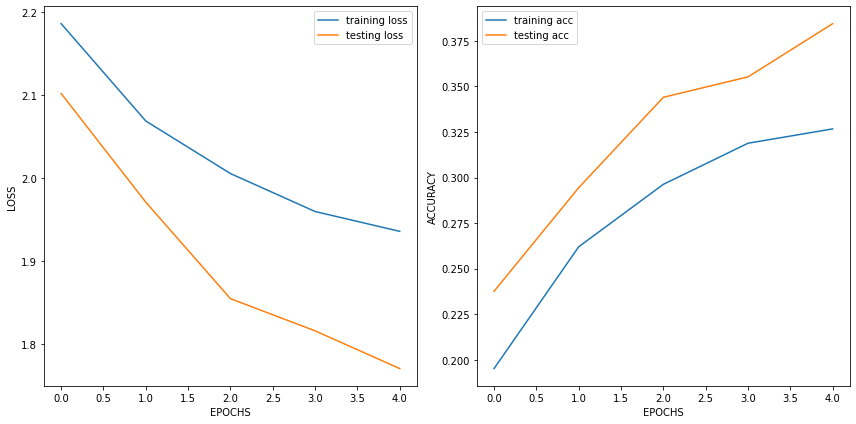


BASELINE MODEL ACCURACY WITH AUG DATA: 38.4%.


In [11]:
print("Using augmented data:")
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode="categorical")
print()

model_3 = tf.keras.models.clone_model(model_1)

model_3.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

model_3.summary()
print()

history_3 = model_3.fit(train_data_aug, epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=test_data,
                        validation_steps=len(test_data))

print()
plot_history(history_3)
acc_3 = model_3.evaluate(test_data, verbose=False)[1]
print(f"\nBASELINE MODEL ACCURACY WITH AUG DATA: {100*acc_3:.1f}%.")

Using augmented data & training for longer:
Found 7500 images belonging to 10 classes.

Model: "Baseline_tinyVGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
____________________________

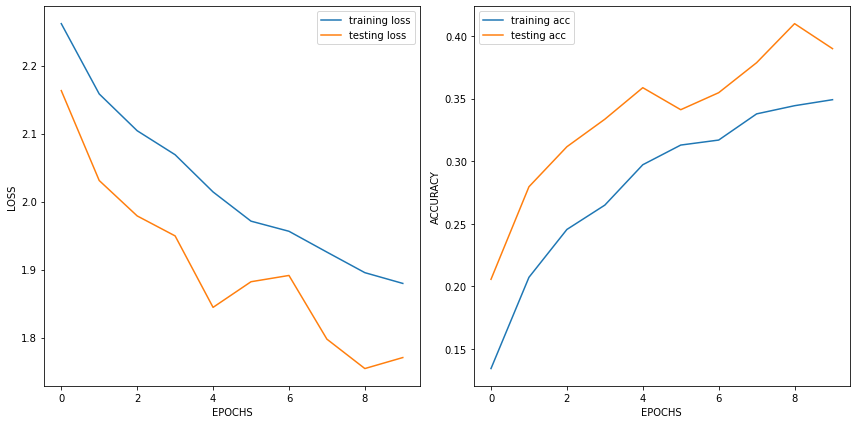


BASELINE MODEL ACCURACY WITH AUG DATA & EXTENDED TRAINING: 39.0%.


In [12]:
print("Using augmented data & training for longer:")
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode="categorical")
print()

model_4 = tf.keras.models.clone_model(model_1)

model_4.compile(loss="categorical_crossentropy",
                      optimizer="adam",
                      metrics=["accuracy"])

model_4.summary()
print()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history_4 = model_4.fit(train_data_aug, epochs=10,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[callback])

print()
plot_history(history_4)
acc_4 = model_4.evaluate(test_data, verbose=False)[1]
print(f"\nBASELINE MODEL ACCURACY WITH AUG DATA & EXTENDED TRAINING: {100*acc_4:.1f}%.")

## Making a prediction with our trained model

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg

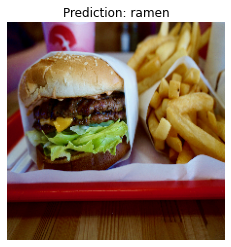

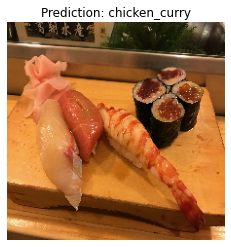

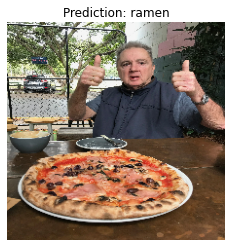

In [14]:
pred_tests = ["03-hamburger.jpeg",
              "03-sushi.jpeg",
              "03-pizza-dad.jpeg"]
              
for img_name in pred_tests:
  pred_and_plot(model_4, img_name, class_names=list(class_names))

## Saving and loading the model

In [15]:
model_4.save("saved_trained_model_4")

INFO:tensorflow:Assets written to: saved_trained_model_4/assets


In [16]:
loaded_model_4 = tf.keras.models.load_model("saved_trained_model_4")
loaded_model_4.evaluate(test_data)

79/79 [==============================] - 13s 163ms/step - loss: 1.7706 - accuracy: 0.3900


[1.7705851793289185, 0.38999998569488525]